# ALX Movie Recommendation Project 2024

## Description

## Challenge Description

- In today’s technology-driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

- ...ever wondered how Netflix, Amazon Prime, Showmax, Disney and the likes somehow know what to recommend to you?


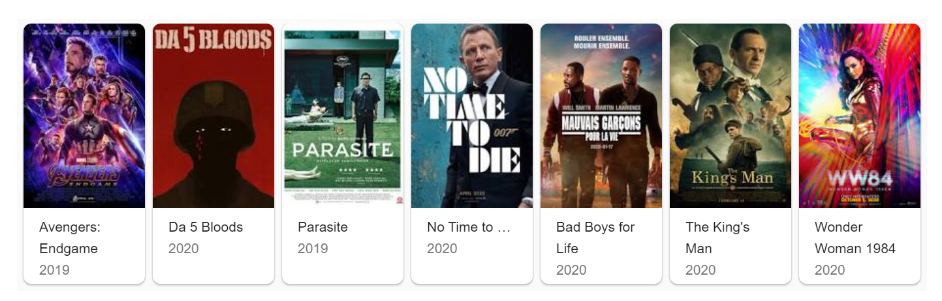

- ...it's not just a guess drawn out of the hat. There is an algorithm behind it.

- With this context, we are challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

## Dataset Overview
We have several datasets:

- train.csv: User ratings for movies.
- test.csv: Movies to predict ratings for.
- movies.csv: Movie metadata including genres.
- genome_scores.csv: Relevance scores for movie-tag pairs.
- genome_tags.csv: Tags used in the genome_scores dataset.
- tags.csv: User tags for movies.
- links.csv: Mapping between MovieLens IDs and other external IDs like IMDb and TMDb.

In [1]:
# loading the  required packages 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
import surprise
from surprise import SVD, Dataset, Reader

- First, let's load all the datasets into Pandas DataFrames. This includes train.csv, test.csv, movies.csv, genome_scores.csv, genome_tags.csv, tags.csv, and links.csv.

In [2]:
import pandas as pd

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
movies = pd.read_csv('movies.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

# Display the first few rows of each dataset
print("Train Data:")
print(train.head())
print("\nTest Data:")
print(test.head())
print("\nMovies Data:")
print(movies.head())
print("\nGenome Scores Data:")
print(genome_scores.head())
print("\nGenome Tags Data:")
print(genome_tags.head())
print("\nTags Data:")
print(tags.head())
print("\nLinks Data:")
print(links.head())


Train Data:
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

Test Data:
   userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Genome Scores Data

In [3]:
# Check for missing values in each dataset
print("Missing values in train data:", train.isnull().sum().sum())
print("Missing values in test data:", test.isnull().sum().sum())
print("Missing values in movies data:", movies.isnull().sum().sum())
print("Missing values in genome_scores data:", genome_scores.isnull().sum().sum())
print("Missing values in genome_tags data:", genome_tags.isnull().sum().sum())
print("Missing values in tags data:", tags.isnull().sum().sum())
print("Missing values in links data:", links.isnull().sum().sum())

Missing values in train data: 0
Missing values in test data: 0
Missing values in movies data: 0
Missing values in genome_scores data: 0
Missing values in genome_tags data: 0
Missing values in tags data: 16
Missing values in links data: 107


In [4]:
train.shape

(10000038, 4)

## Handling Missing Values

In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [6]:
# Display rows with missing values in tags.csv
print(tags[tags.isnull().any(axis=1)])


        userId  movieId  tag   timestamp
860902  121710    33826  NaN  1221450908
976395  141727      123  NaN  1199450867
976396  141727      346  NaN  1199451946
976400  141727     1184  NaN  1199452261
976407  141727     1785  NaN  1199452006
976408  141727     2194  NaN  1199450677
976410  141727     2691  NaN  1199451002
976418  141727     4103  NaN  1199451920
976420  141727     4473  NaN  1199451040
976422  141727     4616  NaN  1199452441
976438  141727     7624  NaN  1199452266
976444  141727     8898  NaN  1199450757
976451  141727    32460  NaN  1199450901
976453  141727    33826  NaN  1199450703
976458  141727    36537  NaN  1199450736
976459  141727    55805  NaN  1199450941


In [7]:
# Fill missing values in the tag column in tags.csv with 'Unknown'
tags['tag'].fillna('Unknown', inplace=True)
print("Missing values in tags data after filling:", tags.isnull().sum().sum())

Missing values in tags data after filling: 0


In [8]:
# Fill missing values in imdbId and tmdbId columns in links.csv with 0
links['imdbId'].fillna(0, inplace=True)
links['tmdbId'].fillna(0, inplace=True)
print("Missing values in links data after filling:", links.isnull().sum().sum())

Missing values in links data after filling: 0


## Merging Datasets

In [9]:
# Merge train data with movies data
train_merged = pd.merge(train, movies, on='movieId', how='left')

# Display the first few rows of the merged dataset
train_merged.head()


,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [10]:
# Merge test data with movies data
test_merged = pd.merge(test, movies, on='movieId', how='left')
test_merged.head()

,userId,movieId,title,genres
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1,1,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance
2,1,5767,Teddy Bear (Mis) (1981),Comedy|Crime
3,1,6711,Lost in Translation (2003),Comedy|Drama|Romance
4,1,7318,"Passion of the Christ, The (2004)",Drama


In [11]:
# Concatenate tags for each movie-user pair
tags_concatenated = tags.groupby(['userId', 'movieId'])['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge concatenated tags with train data
train_merged_with_tags = pd.merge(train_merged, tags_concatenated, on=['userId', 'movieId'], how='left')

# Merge concatenated tags with test data
test_merged_with_tags = pd.merge(test_merged, tags_concatenated, on=['userId', 'movieId'], how='left')

# Fill NaN values in the tag column with 'Unknown'
train_merged_with_tags['tag'].fillna('Unknown', inplace=True)
test_merged_with_tags['tag'].fillna('Unknown', inplace=True)

In [12]:
# Display the first few rows of the merged datasets with tags
train_merged_with_tags.head()


,userId,movieId,rating,timestamp,title,genres,tag
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Unknown
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Unknown
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Unknown
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Unknown
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Unknown


In [13]:
# Display the first few rows of the merged datasets with tags
test_merged_with_tags.head()


,userId,movieId,title,genres,tag
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,Unknown
1,1,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance,Unknown
2,1,5767,Teddy Bear (Mis) (1981),Comedy|Crime,Unknown
3,1,6711,Lost in Translation (2003),Comedy|Drama|Romance,Unknown
4,1,7318,"Passion of the Christ, The (2004)",Drama,Unknown


In [14]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [15]:
# Merge genome_scores with genome_tags on 'tagId'
genome_data = pd.merge(genome_scores, genome_tags, on='tagId', how='left')

# Display the first few rows of genome_data
genome_data.head()


,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s


In [16]:
genome_data.tail()


,movieId,tagId,relevance,tag
15584443,206499,1124,0.11000,writing
15584444,206499,1125,0.04850,wuxia
15584445,206499,1126,0.01325,wwii
15584446,206499,1127,0.14025,zombie
15584447,206499,1128,0.03350,zombies


# Exploratory Data Analysis (EDA)
- Distribution of Ratings

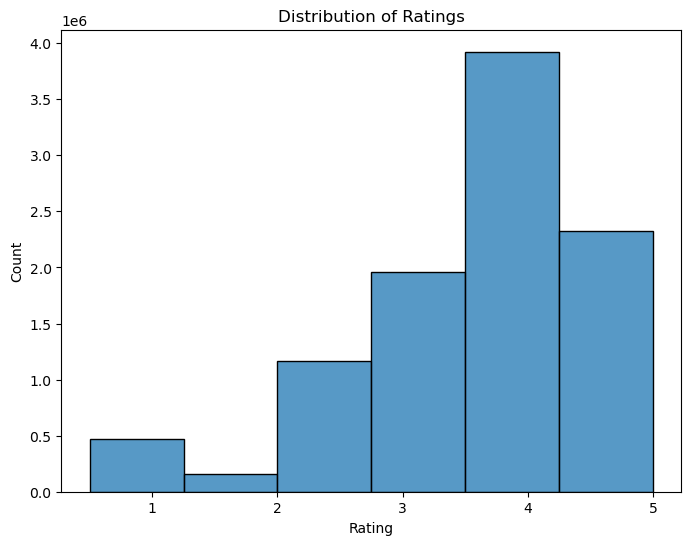

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(train['rating'], bins=6, kde=False)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


-  Movie Popularity

In [18]:
# Count the number of ratings per movie
movie_rating_counts = train['movieId'].value_counts()

# Display the most and least rated movies
most_rated_movies = movie_rating_counts.head(10)
least_rated_movies = movie_rating_counts.tail(10)

print("Most Rated Movies:")
print(most_rated_movies)

print("\nLeast Rated Movies:")
print(least_rated_movies)


Most Rated Movies:
318     32831
356     32383
296     31697
593     29444
2571    29014
260     27560
480     25518
527     24004
110     23722
2959    23536
Name: movieId, dtype: int64

Least Rated Movies:
164129    1
177599    1
152481    1
79124     1
176789    1
122409    1
98473     1
109177    1
186455    1
97148     1
Name: movieId, dtype: int64


-  User Activity

In [19]:
# Count the number of ratings per user
user_rating_counts = train['userId'].value_counts()

# Display the most active and least active users
most_active_users = user_rating_counts.head(10)
least_active_users = user_rating_counts.tail(10)

print("Most Active Users:")
print(most_active_users)

print("\nLeast Active Users:")
print(least_active_users)


Most Active Users:
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
109731     2671
49403      2670
92046      2579
110971     2288
30879      2284
Name: userId, dtype: int64

Least Active Users:
60219     2
45003     2
153150    2
120862    2
53640     1
127098    1
121071    1
55362     1
105714    1
79087     1
Name: userId, dtype: int64


In [20]:
print("Columns in train_merged_with_tags:", train_merged_with_tags.columns)
print("Columns in test_merged_with_tags:", test_merged_with_tags.columns)


Columns in train_merged_with_tags: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'tag'], dtype='object')
Columns in test_merged_with_tags: Index(['userId', 'movieId', 'title', 'genres', 'tag'], dtype='object')


In [21]:
import pandas as pd

# Convert timestamp to datetime in train_merged_with_tags
train_merged_with_tags['timestamp'] = pd.to_datetime(train_merged_with_tags['timestamp'], unit='s')

# Extract year, month, and day from timestamp in train_merged_with_tags
train_merged_with_tags['year'] = train_merged_with_tags['timestamp'].dt.year
train_merged_with_tags['month'] = train_merged_with_tags['timestamp'].dt.month
train_merged_with_tags['day'] = train_merged_with_tags['timestamp'].dt.day

# Display the first few rows of the train data with new datetime features
train_merged_with_tags.head()


,userId,movieId,rating,timestamp,title,genres,tag,year,month,day
0,5163,57669,4.0,2018-02-11 11:53:12,In Bruges (2008),Comedy|Crime|Drama|Thriller,Unknown,2018,2,11
1,106343,5,4.5,2008-03-23 02:18:59,Father of the Bride Part II (1995),Comedy,Unknown,2008,3,23
2,146790,5459,5.0,2004-02-08 04:45:39,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Unknown,2004,2,8
3,106362,32296,2.0,2015-02-04 09:36:05,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Unknown,2015,2,4
4,9041,366,3.0,1996-05-29 13:17:17,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Unknown,1996,5,29


In [22]:
print(train_merged_with_tags.shape)

(10000038, 10)


In [23]:
train_merged_with_tags.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
year         0
month        0
day          0
dtype: int64

In [24]:
test_merged_with_tags.head()

,userId,movieId,title,genres,tag
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,Unknown
1,1,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance,Unknown
2,1,5767,Teddy Bear (Mis) (1981),Comedy|Crime,Unknown
3,1,6711,Lost in Translation (2003),Comedy|Drama|Romance,Unknown
4,1,7318,"Passion of the Christ, The (2004)",Drama,Unknown


In [25]:
test_merged_with_tags.shape

(5000019, 5)

In [26]:
test_merged_with_tags.isnull().sum()

userId     0
movieId    0
title      0
genres     0
tag        0
dtype: int64

In [27]:
print(test_merged_with_tags[['tag']].isnull().sum())


tag    0
dtype: int64


In [28]:
# Prepare data for surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train_merged_with_tags[['userId', 'movieId', 'rating']], reader)

# Hyperpramter Tuining

In [ ]:
# Required imports
import pandas as pd
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import GridSearchCV


print('Performing hyperparameter tuning ...')

# Parameter grid for GridSearchCV
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

# Define Reader object for surprise
reader = Reader(rating_scale=(0.5, 5.0))

# Load data into surprise Dataset
data = Dataset.load_from_df(train_merged_with_tags[['userId', 'movieId', 'rating']], reader)

# Perform GridSearchCV
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Output the best score and parameters
print(f"Best RMSE: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")


Performing hyperparameter tuning ...


In [ ]:
#Train models
print('Training models....')

svd = gs.best_estimator ["rmse"]
knn = KNNWithMeans(k = 40, min_k = 2, sim_options = ('name': 'pearson_baseline', 'user_based': False))
slope_one = SlopeOne()

trainset = data.build_full_trainset()
svd.fit(trainset)
knn.fit(trainset)
slope_one.fit(trainset)

In [ ]:
# preapre additional features
print ("Prepoaring additional features......")
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(token_pattern = r'\b\w+\b')
genre_matrix = tfidf.fit_transform(movies['genres'])


global_mean = train_merged_with_tags['rating'].mean()
user_biases = train_merged_with_tags.groupby('userId')['rating'].mean() - global_mean
movie_biases = train_merged_with_tags.groupby('movieId')['rating'].mean() - global_mean


def ensemble_predict(user, item):
    svd_pred = svd.predict(user, item).est
    knn_pred = knn.predict(user, item).est
    slope_one_pred = slope_one.predict(user, item).est
    
    user_bias = user_bias.get(user, 0)
    movie_bias = movie_biases.get(item, 0)
    
    
    genre_features = genre_matrix[movies['movieId'] == item].toarray().flatten()
    genre_weight = 0.1
    
    
    ensemble_pred = (svd_pred + knn_pred + slope_one_pred) / 3
    final_pred = ensemble_pred + user_bias + movie_bias + genre_weight * np.mean(genre_features)
    
    
    return max (0.5, min(5.0, final_pred))

In [ ]:
# create test parirs
test_pairs = set(test_merged_with_tags.apply(lambda row f"{row['userId']}_{row['movieId']}", axis = 1))

def get_predictions_batch(test_pairs, batch_size = 1000):
    predictions = {}
    
    for i in tqdm(range (0, len(test_pairs), batch_size)):
        batch_pairs = list(test_pairs)[i:i+batch_size] 
        for pair in batch_pairs:
            user. movie = map(int, pair.split('_'))
            est = ensemble_predict(user, movie)
            predictions[pair] = est
            
    return predictions        

# finding optimal batch_size

In [ ]:
print("Finding optimal batch seize....")

batch_sizes = [1000, 5000, 10000, 20000]
optimal_batch_size = 1000
min_time = float('inf')


for batch_size in batch_sizes:
    start_time = time.time()
    _ = get_predictions_batch(list(test_pairs)[:10000], batch_size = batch_size)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Batch suze {batch_size}: {elapsed_time:2f} seconds")
    if elapsed_time < min_time:
        min_time = elapsed_time
        optimal_batch_size = batch_size
        
print(f"Optimal batch size: {optimal_batch_size}"")        

In [ ]:
# predictions generated
predictions = get_predictions_batch(test_pairs, batch_size = optimal_batch_size)

In [ ]:
# sumission dataframe
submission = pd.DataFrame.from_dict(predictions, orient = 'index', columns = ['rating'])
submission.index.name - 'Id'
submission.reset_index(inplace = True)

In [ ]:
#Saving
submission.to_csv(submission.csv, index = False)
